# Introduction

Dear viewers, welcome! <br>
We are **Ben Arviv** and **Daniel Dubinskey**, computer science students from the **Open University of Israel**, leaning towards the fields of *Data Science* and *Machine Learning*. <br>
In the *Data Science Workshop* (20936) we learned many tools and techniques for data analysis and machine learning, and for our final project we chose to focus on the field of *Computer Vision* and *Deep Learning*. As a result, we decided to perform a data science project on a dataset we found on Kaggle, which is called **Brain Tumor Detection**.

The main goal of the project is to contribute to the early detection and diagnosis of brain tumors, which aims to provide valuable support to medical professionals in creating effective treatment plans. The dataset consists of brain scans and has a diverse range of brain tumor images that are annotated to highlight the tumor regions.

## The Problem

Brain tumor detection presents multifaceted challenges stemming from the complexity and heterogeneity of brain tumors, coupled with the limitations of current diagnostic techniques. Early detection is hindered by the nonspecific nature of symptoms in the initial stages, often leading to delayed diagnosis until tumors have progressed. <br>
Imaging modalities like MRI and CT scans, while essential, require expert interpretation and may miss subtle or small tumors, especially given the intricate anatomy of the brain. Furthermore, invasive biopsy procedures for definitive diagnosis pose risks and are not always feasible or desirable. Tumor heterogeneity exacerbates the difficulty in developing universal detection methods, and the overlap of tumor tissue with normal brain structures complicates interpretation.

Access to advanced imaging and diagnostic procedures, along with the high cost, further exacerbates disparities in healthcare access. Moreover, the need for large, diverse datasets for training AI algorithms adds another layer of complexity. Addressing these challenges necessitates collaborative efforts across disciplines to innovate non-invasive detection methods, improve imaging technology, and harness AI for more accurate and accessible brain tumor diagnosis, ultimately improving patient outcomes.

In this computer vision project, we aim to develop a brain tumor detection system leveraging a dataset comprising brain scans as input images and corresponding labels denoting the coordinates of brain tumors, where present. By harnessing advanced image processing and deep learning techniques, our objective is to accurately identify and localize brain tumors within medical imaging data. The dataset serves as a critical resource for training and evaluating our model, enabling it to learn complex patterns and features indicative of tumor presence. Through precise localization of tumors within brain scans, our system can assist healthcare professionals in early diagnosis, treatment planning, and monitoring of patients with neurological conditions. By automating the detection process, we aim to enhance efficiency, reduce human error, and ultimately improve patient outcomes in the diagnosis and management of brain tumors.

# Exploratory Data Analysis (EDA)

In order to understand the dataset and the problem we are dealing with, we will perform an exploratory data analysis (EDA) to get a sense of the data and its characteristics. This process includes examining the distribution of the data, identifying patterns and trends, applying dimensionality reduction and clustering techniques, and visualizing the data to gain insights. EDA is a crucial step in the data science process, as it helps us understand the data, identify potential issues, and inform subsequent steps in the analysis and modeling process.

In [1]:
# For running purposes, we need to install the following package
# !pip install ultralytics

In [2]:
import os
import shutil
import random
import cv2
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

In [3]:
# Set the paths to the dataset
TRAIN_PATH = os.path.join(os.getcwd(), 'train')
VALID_PATH = os.path.join(os.getcwd(), 'valid')
TEST_PATH = os.path.join(os.getcwd(), 'test')

TRAIN_IMAGE_PATH = os.path.join(TRAIN_PATH, 'images')
VALID_IMAGE_PATH = os.path.join(VALID_PATH, 'images')
TEST_IMAGE_PATH = os.path.join(TEST_PATH, 'images')

TRAIN_LABEL_PATH = os.path.join(TRAIN_PATH, 'labels')
VALID_LABEL_PATH = os.path.join(VALID_PATH, 'labels')
TEST_LABEL_PATH = os.path.join(TEST_PATH, 'labels')

IMG_WIDTH = 139
IMG_HEIGHT = 132

Let's see what our files look like.

In [4]:
os.listdir(TRAIN_IMAGE_PATH)[:5], os.listdir(TRAIN_LABEL_PATH)[:5]

(['volume_46_slice_61_jpg.rf.391e59308aa61a1c6184a0f2d41b62f2.jpg',
  'volume_198_slice_79_jpg.rf.8c7c23a1ab721c83b4025175fcb7a034.jpg',
  'volume_323_slice_31_jpg.rf.e21e68e7259f11cb7b9c1f5ceabcf503.jpg',
  'volume_151_slice_60_jpg.rf.972f02fcc6ef2e356bdfe78ac13a35c5.jpg',
  'volume_320_slice_105_jpg.rf.ad0d93f902dba9aa847e8928ed820611.jpg'],
 ['volume_318_slice_69_jpg.rf.941f970f981354db43bccf56555bc583.txt',
  'volume_266_slice_93_jpg.rf.35488329cea5924cf8080ce006349872.txt',
  'volume_308_slice_60_jpg.rf.3ab6c84b34debdcdf892ed3348648954.txt',
  'volume_76_slice_91_jpg.rf.ebbcc4f8d29cac3a6cc80676862d87de.txt',
  'volume_99_slice_62_jpg.rf.1e748984d94cccdaa9b499eada463fe4.txt'])

It appears that the images are in `jpg` format, and the labels are in `txt` format. We will start by loading the data and examining the contents of the dataset.

In [5]:
file_paths = [os.path.join(TRAIN_LABEL_PATH, file) for file in os.listdir(TRAIN_LABEL_PATH)[:5]]

files = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        files.append(file.read())

files


['0 0.30935251798561153 0.3106060606060606 0.5179856115107914 0.4696969696969697\n1 0.3237410071942446 0.3371212121212121 0.60431654676259 0.5681818181818182',
 '0 0.38489208633093525 0.7878787878787878 0.30935251798561153 0.25757575757575757\n1 0.4316546762589928 0.7727272727272727 0.3597122302158273 0.3333333333333333',
 '1 0.3345323741007194 0.2689393939393939 0.2517985611510791 0.09848484848484848',
 '0 0.8129496402877698 0.3977272727272727 0.18705035971223022 0.1590909090909091\n1 0.7805755395683454 0.35984848484848486 0.381294964028777 0.2196969696969697\n2 0.8201438848920863 0.4053030303030303 0.17266187050359713 0.1590909090909091',
 '1 0.7194244604316546 0.7159090909090909 0.07194244604316546 0.03787878787878788']

Each label file contains zero or more rows, each row contains an index number and the coordinates of the tumor in the image. We have noticed that the labels start with an index number between 0-2, but that number isn't consistent among the labels, we will come back to this later. The coordinates are in the format $(x, y, width, height)$, where $(x, y)$ is the center of the bounding box, and $width$ and $height$ are the dimensions of the bounding box. We will use this information to visualize the bounding boxes on the images and gain insights into the distribution and characteristics of the tumors.

Next, we have to check that the data is consistent, i.e., that each image has a corresponding label file and that there are no duplicate images or labels.

In [6]:
def has_label(image_name, label_path):
    return os.path.exists(os.path.join(label_path, image_name))

def check_for_duplicates(files):
    seen = set()
    dups = list()
    
    for file in files:
        if file in seen:
            dups.append(file)
        seen.add(file)
    
    return len(dups)

def data_check(path):
    counter = 0
    dups = 0
    label_path = path.replace('images', 'labels')
    images = os.listdir(path)
    labels = os.listdir(label_path)
    
    print(f'Checking: {path}')
    
    # Checks for duplicates in the dataset
    dups = check_for_duplicates(images)
    print(f'Number of duplicate images: {dups}')
    
    dups = check_for_duplicates(labels)
    print(f'Number of duplicate labels: {dups}')
    
    # Counts images without labels
    for image_name in images:
        image_name = image_name.replace('.jpg', '.txt')
        if not has_label(image_name, label_path):
            counter += 1
    print(f"Number of images without labels: {counter}")
    
    return counter


In [7]:
def extract_labels(original_folder, new_folder, idx):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
        
    for filename in os.listdir(original_folder):
        with open(os.path.join(original_folder, filename), 'r') as f:
            lines = f.readlines()
            
        lines_id = [line for line in lines if line.startswith(idx)]
        
        with open(os.path.join(new_folder, filename), 'w') as f:
            if lines_id:
                f.writelines(lines_id)

In [9]:
paths = [TRAIN_IMAGE_PATH, VALID_IMAGE_PATH, TEST_IMAGE_PATH]
for path in paths:
    data_check(path)
    print()

Checking: /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/train/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0

Checking: /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/valid/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0

Checking: /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/test/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0



We see that each image has a corresponding label file, which means that we have a one-to-one mapping between images and labels. This will allow us to associate the tumor annotations with the corresponding images and use them for training and evaluation of our model. We also verified that there are no duplicate images or labels in the dataset, ensuring that the data is clean and consistent.

Using the `cv2` library, we can read the images properly.

In [10]:
def read_images(imgs_path):
    images = []
    
    for img_name in os.listdir(imgs_path):
        img = cv2.imread(os.path.join(imgs_path, img_name))
        images.append(img)
        
    return images

In [11]:
# Load train images
train_images = read_images(TRAIN_IMAGE_PATH)

In [12]:
train_images[0].shape, train_images[0]

((132, 139, 3),
 array([[[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        ...,
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]]], dtype=uint8))

Each image is a 3D array, where the first two dimensions represent the pixel values of the image, and the third dimension represents the color channels (RGB). 

In order to visualize the images and bounding boxes, we will use the `matplotlib` library. Specifically, will use the `imshow` function to display the images.

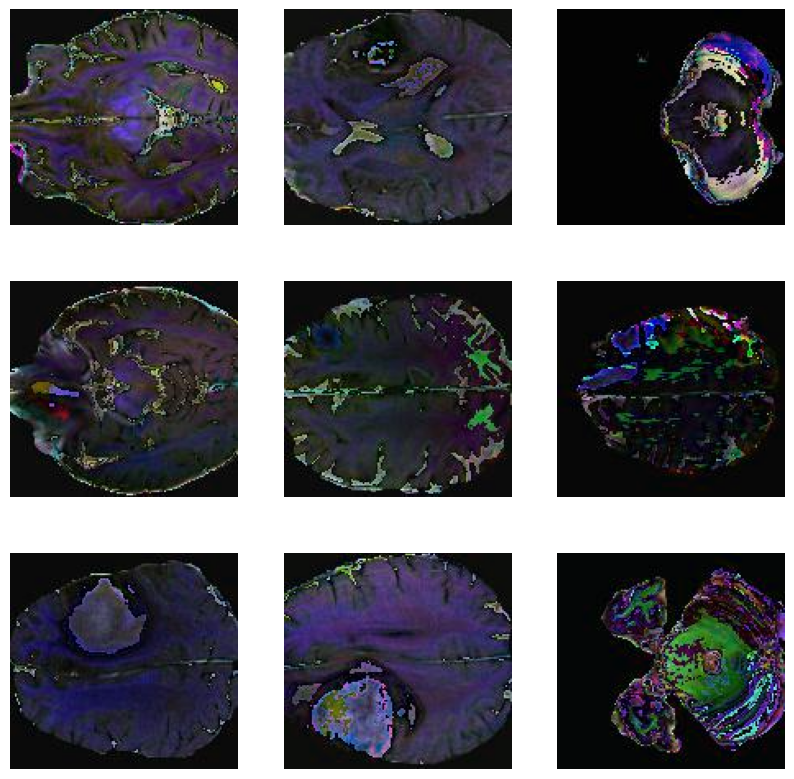

In [ ]:
# Plot images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_images[i])
    ax.axis('off')

All of the images are brain scans, in what appears to be different axial depths of the brain, according to the actual brain scan and color of the image. All of the images are of the same size, and they may or may not contain tumors. 

In [ ]:
print(train_images[0].shape)

(132, 139, 3)


Now it's time to load the labels. We will create a *DataFrame* object to store the labels, with each row representing an image and its corresponding tumor coordinates, sizes and average size (if present). This will allow us to easily access and manipulate the labels, and merge them with the image data for visualization and analysis.

The following function will extract the labels from the label files and store them in a *DataFrame* object, along with the number of tumors in each image, the sizes of the tumors and the average size of them.

In [14]:
def read_labels(lbls_path, imgs_path, images):
    labels = pd.DataFrame(columns=['number of tumors', 'list of tumors', 'sizes of tumors'])
    unincluded = 0
    flag = False

    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            boxes_list = []
            sizes_list = []
            if len(lines) == 0:
                labels.loc[i] = [0, [], []]
                continue
            
            for line in lines:
                line = line.strip().split()
                
                idx, x, y, width, height = list(map(float, line))
                xmin = (x - width / 2) * IMG_WIDTH 
                ymin = (y - height / 2) * IMG_HEIGHT
                xmax = (x + width / 2) * IMG_WIDTH
                ymax = (y + height / 2) * IMG_HEIGHT 
                
                size = (width / IMG_WIDTH) * (height / IMG_HEIGHT)
                sizes_list.append([size])
                boxes_list.append([xmin, ymin, xmax, ymax])
            
                
            labels.loc[i] = [len(boxes_list), boxes_list, sizes_list]
            
    labels['average tumor size'] = labels['sizes of tumors'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
    
    return labels

We can use the `head` function to display the first few rows of the labels *DataFrame*. This information will be used to analyze the distribution of tumors in the dataset, calculate statistics on tumor sizes, and visualize the tumors on the images.

In [ ]:
# Load train labels
train_labels = read_labels(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH, train_images)
train_labels.head()

number of tumors                                     list of tumors  \
0                 1  [[23.000000000000004, 68.0, 95.99999999999999,...   
1                 3  [[52.0, 18.999999999999996, 78.0, 39.0], [37.0...   
2                 1            [[48.0, 25.0, 53.99999999999999, 32.0]]   
3                 3  [[0.9999999999999996, 66.0, 23.999999999999996...   
4                 2  [[5.999999999999999, 18.0, 40.0, 49.0], [21.0,...   

                                     sizes of tumors  average tumor size  
0                          [[9.107405793065767e-06]]        9.107406e-06  
1  [[1.5446350333966729e-06], [1.0040127717078374...        5.002241e-06  
2                         [[1.2475898346665436e-07]]        1.247590e-07  
3  [[1.2980875184506655e-06], [6.546876180012053e...        3.333837e-06  
4  [[3.1308563946155642e-06], [5.792381375237524e...        1.855047e-06

The `describe()` function

In [13]:
def read_labels_by_index(lbls_path, imgs_path, images):
    labels = {'0': [], '1': [], '2': []}
    
    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            if len(lines) == 0:
                continue
            
            for line in lines:
                line = line.strip().split()
                
                idx, x, y, width, height = list(map(float, line))
                size = (width * IMG_WIDTH) * (height * IMG_HEIGHT)
                
                labels[str(int(idx))].append(size)
        
    return labels

In [15]:
def read_cleaned_labels(lbls_path, imgs_path):
    labels = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'size'])
    
    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        
        with open(file_path, 'r') as file:
            line = file.readlines()
            if len(line) == 0: # if there are no tumors in the image
                labels.loc[i] = [0, 0, 0, 0, 0]
                continue
            line = line[0].split()
            idx, x, y, width, height = list(map(float, line))
            
            xmin = (x - width / 2) * IMG_WIDTH
            ymin = (y - height / 2) * IMG_HEIGHT
            xmax = (x + width / 2) * IMG_WIDTH
            ymax = (y + height / 2) * IMG_HEIGHT
            size = (width / IMG_WIDTH) * (height / IMG_HEIGHT)
            
            labels.loc[i] = [xmin, ymin, xmax, ymax, size]
            
    return labels

In [16]:
def count_labels(path):
    dict = {0:0, 1:0, 2:0}
    for i, file in enumerate(os.listdir(path)):
        file = os.path.join(path, file)
        with open(file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split()
                idx, x, y, w, h = list(map(float,line))
                dict[idx] += 1
    keys = list(dict.keys())
    values = list(dict.values())
    
    plt.bar(keys, values, color=['red', 'green', 'blue'])
    plt.xticks(keys)
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    plt.title('Frequency of Tumors by Index')
    plt.show()

In [17]:
def count_0_2_indices(path):
    cnt = 0
    paths = []
    for i, file_path in enumerate(os.listdir(path)):
        file_path = os.path.join(path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            if len(lines) == 1: 
                for line in lines: 
                    line = line.strip().split() 
                    idx, x, y, width, height = list(map(float, line))
                    if (idx!=1):
                        cnt +=1
                        paths.append(file_path)
    return cnt, paths

In [18]:
def get_dimensions(df):
    width = df['xmax'] - df['xmin']
    height = df['ymax'] - df['ymin']
    aspect_ratios = width / height

    return aspect_ratios

In [20]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6930 entries, 0 to 6929
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number of tumors    6930 non-null   int64  
 1   list of tumors      6930 non-null   object 
 2   sizes of tumors     6930 non-null   object 
 3   average tumor size  6930 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 270.7+ KB


In [21]:
train_labels.describe()

number of tumors  average tumor size
count       6930.000000         6930.000000
mean           2.170418            0.000005
std            0.916938            0.000004
min            0.000000            0.000000
25%            1.000000            0.000002
50%            3.000000            0.000004
75%            3.000000            0.000007
max            3.000000            0.000030

Are there any images with no tumor annotations? Let's check.

In [22]:
without_tumor = len(train_labels[train_labels['number of tumors'] == 0])
without_tumor

79

Only 79. 

Only 79. This is a very small number compared to the total number of images we have - 6930, therefore we can consider them as outliers and remove them from the dataset, as they will not contribute to the training of our model. It seems now that our model will detect the tumor in the images, but not the absence of a tumor.

Perhaps now it is a good time to figure out what the index number in the labels represents.

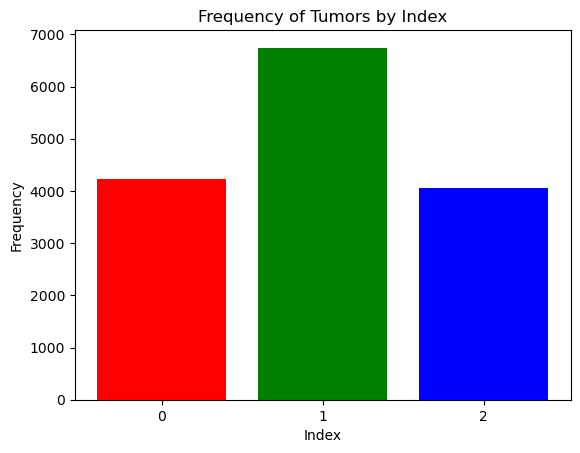

In [23]:
count_labels(TRAIN_LABEL_PATH)

It looks like index 1 is the most common index in the labels, and appears in almost 7000 images - basically, all of the training images. Indices 0 and 2 are less common, and appear in about $\frac{2}{3}$ of the images. Are there any images that contain the index 0 or 2 but not 1?

In [24]:
count, no_1_paths = count_0_2_indices(TRAIN_LABEL_PATH) 
print('Number of 0 and 2 indices: ', count)

Number of 0 and 2 indices:  55


Not too much - only 55 images. Since our dataset is relatively large, we can afford to remove these images from the dataset.

Now, what about the sizes of the tumors? Is there any correlation between the size of the tumor and the index?

In [25]:
labels_dict = read_labels_by_index(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH, train_images)
avgs = []

for key in labels_dict.keys():
    avgs.append(np.mean(labels_dict[key]))
    
for i in range(len(avgs)):
    print(f'Average size of index {i}: {avgs[i]}')

Average size of index 0: 1182.2640396413403
Average size of index 1: 2664.2779836916234
Average size of index 2: 1190.2999014292755


Thing are starting to get interesting. The average size of the tumors in the images with index 1 is significantly larger than those with index 0 or 2. However, the average size of the tumors with indices 0 and 2 is pretty similar. We should dig a little deeper here, we might onto something.

Let's try the next plot, of bounding boxes taken from images that contain all three indices.

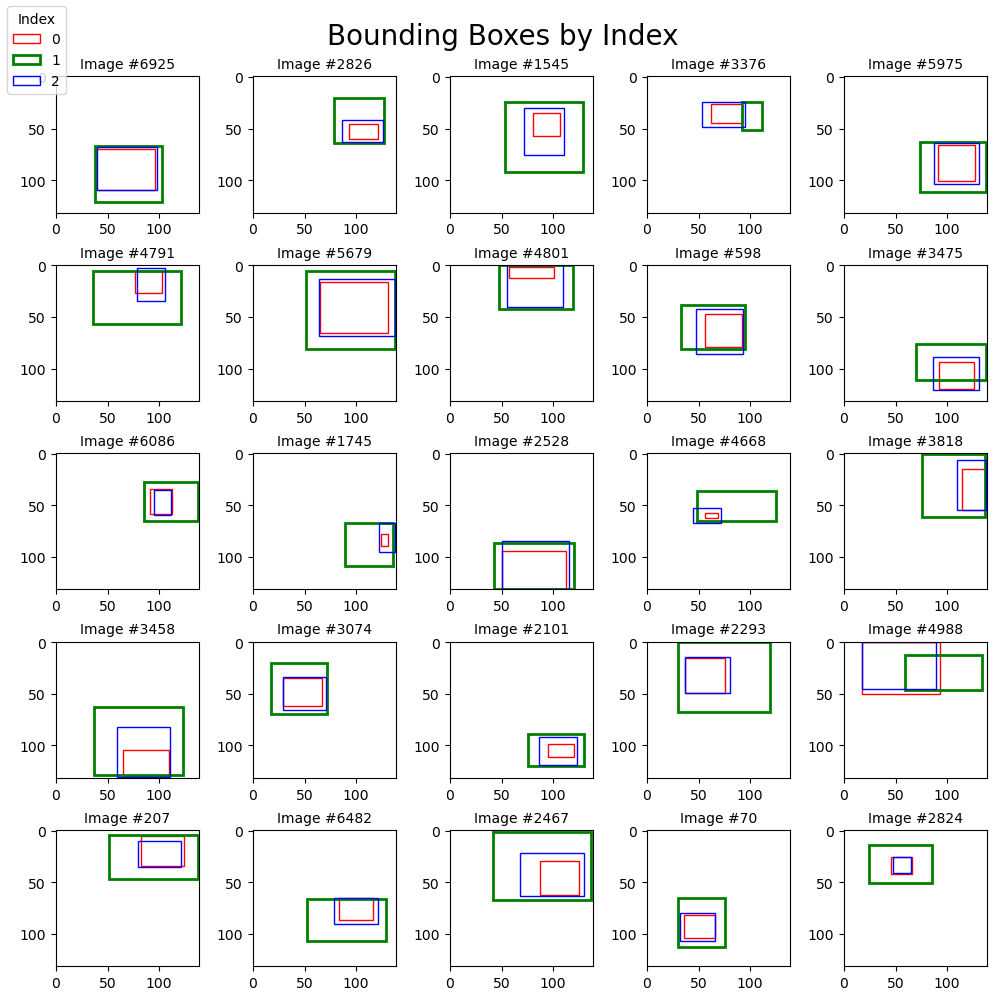

In [26]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Bounding Boxes by Index', fontsize=20)

image = np.ones((132, 139, 3), dtype=np.uint8) * 255
temp = random.randint(0, len(train_images))
colors = ['r', 'g', 'b']
width = [1, 2, 1]
printed = []
for i, ax in enumerate(axes.flat):
    flag = True
    while flag:
        if temp not in printed and train_labels['number of tumors'].loc[temp] == 3:
            flag = False
            for j, box in enumerate(train_labels['list of tumors'].loc[temp]):
                xmin, ymin, xmax, ymax = box
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=colors[j], linewidth=width[j])
                ax.add_patch(rect)
                ax.set_title(f'Image #{temp}', fontsize=10)
                ax.imshow(image)
        printed.append(temp)
        temp = random.randint(0, len(train_images))
          
plt.figlegend(['0', '1', '2'], loc='upper left', title='Index')
plt.tight_layout()
plt.show()

Bingo! Kind of. In most of the images, the bounding boxes with index 1 contain the bounding boxes with indices 0 and 2. This means that the bounding boxes with index 1 are the least precise, and all of the boxes in fact represent the same tumor. This is a very important insight, as it means that we can treat all of the bounding boxes as the same tumor, and we can use the bounding boxes with index 1 to train our model. 

In that case, it is good to perform some data cleaning and remove the bounding boxes with indices 0 and 2 from the labels. The following code will do that.

In [ ]:
def clean_data(data_path, dir):
    os.makedirs('Clean',exist_ok=True)
    data_path = os.path.join(data_path, 'Clean')
    
    os.makedirs(os.path.join(data_path, dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(data_path, dir, 'labels'), exist_ok=True)

    labels_path = os.path.join(os.getcwd(), dir, 'labels')
    img_path = os.path.join(os.getcwd(), dir, 'images')

    new_labels_path = os.path.join(data_path, dir, 'labels')
    new_images_path = os.path.join(data_path, dir, 'images')
    
    for file_name in os.listdir(labels_path):
        file_path  = os.path.join(labels_path, file_name)
        with open(file_path, 'r') as f:
            image_file_name = file_name.replace('.txt', '.jpg')
            image_file_path = os.path.join(img_path, image_file_name)
            lines = f.readlines()
            lines_id = [line for line in lines if line.startswith('1')]
            if lines_id:
                with open(os.path.join(new_labels_path, file_name), 'w') as f: 
                    lines_id = lines_id[0].split(' ')
                    lines_id[0] = '0 '
                    lines_id = ' '.join(lines_id)
                    lines_id = lines_id.strip()
                    f.writelines(lines_id)
                    shutil.copy(image_file_path, new_images_path)
            
    

In [27]:
folders = ['train', 'valid', 'test']
for folder in folders:
    clean_data(os.getcwd(), folder)

We need to refresh the labels to proceed with our analysis, focusing solely on the bounding boxes labeled as index 1. These updated labels will be housed in a new DataFrame object, presenting the data in a more user-friendly manner. This DataFrame will include the coordinates for the bottom left and top right corners of each bounding box, along with the dimensions of the bounding box.

In [28]:
TRAIN_PATH = os.path.join(os.getcwd(), 'Clean', 'train')
VALID_PATH = os.path.join(os.getcwd(), 'Clean', 'valid')
TEST_PATH = os.path.join(os.getcwd(), 'Clean', 'test')

TRAIN_IMAGE_PATH = os.path.join(TRAIN_PATH, 'images')
VALID_IMAGE_PATH = os.path.join(VALID_PATH, 'images')
TEST_IMAGE_PATH = os.path.join(TEST_PATH, 'images')

TRAIN_LABEL_PATH = os.path.join(TRAIN_PATH, 'labels')
VALID_LABEL_PATH = os.path.join(VALID_PATH, 'labels')
TEST_LABEL_PATH = os.path.join(TEST_PATH, 'labels')

In [29]:
train_labels = read_cleaned_labels(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH)
train_labels.head()

xmin  ymin   xmax   ymax          size
0  23.0  68.0   96.0  110.0  9.107406e-06
1  37.0   3.0  102.0   55.0  1.004013e-05
2  48.0  25.0   54.0   32.0  1.247590e-07
3   9.0  59.0   67.0   97.0  6.546876e-06
4   6.0  18.0   40.0   49.0  3.130856e-06

In [30]:
train_labels.describe()

xmin         ymin         xmax         ymax          size
count  6745.000000  6745.000000  6745.000000  6745.000000  6.745000e+03
mean     44.700519    46.134025   100.297999    86.937139  7.914110e-06
std      28.661239    31.994673    27.084511    30.747805  6.088556e-06
min       0.000000     0.000000    15.000000    10.000000  2.970452e-09
25%      25.000000    15.000000    79.000000    59.000000  3.077388e-06
50%      41.000000    46.000000   104.000000    89.000000  6.941946e-06
75%      66.000000    75.000000   123.000000   117.000000  1.128772e-05
max     137.000000   127.000000   139.000000   132.000000  4.272995e-05

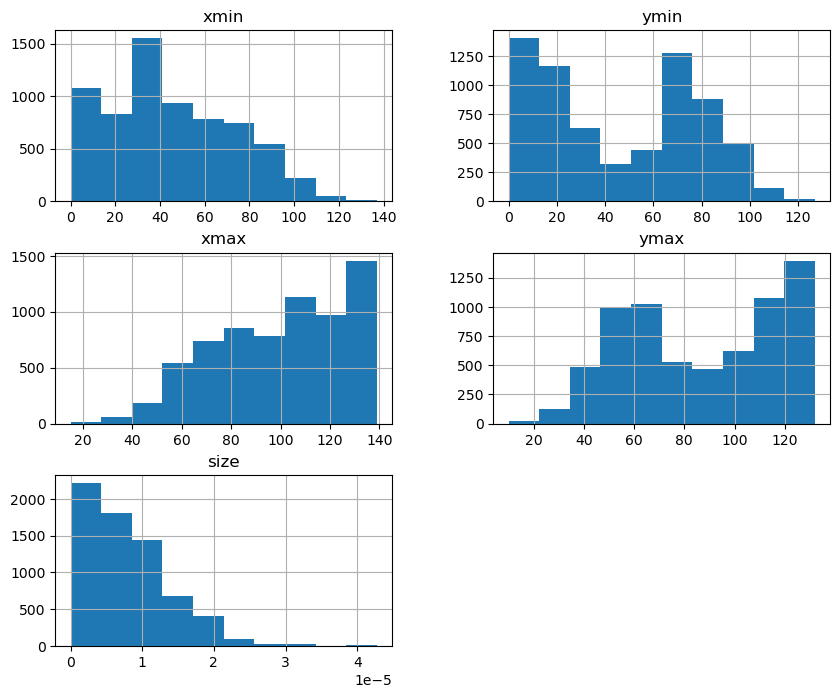

In [31]:
train_labels.hist(figsize=(10, 8))
plt.show()

The coordinates of the bounding boxes don't provide significant insights about the tumors, however, the size histogram is quite revealing. It's evident that the majority of tumors share a similar size, with a few exceptions being larger. This right-skewed distribution could potentially bias our model towards detecting small to medium-sized tumors, which may negatively impact its ability to accurately predict larger tumors. We should keep this in mind when training and evaluating our model. 

We already saw that the bounding boxes have different sizes. Let's have a look at the distribution of the aspect ratios of the bounding boxes.

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Bounding Box Aspect Ratio Distribution')

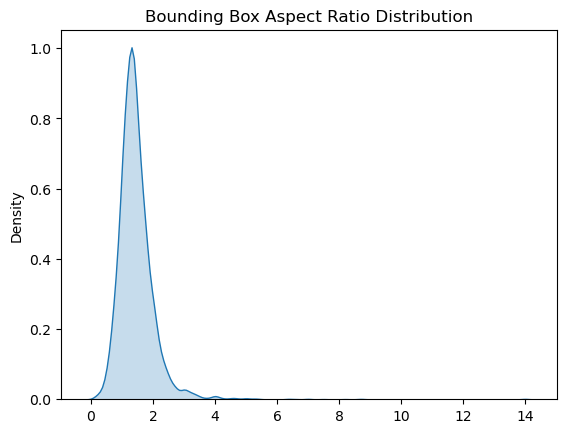

In [32]:
aspect_ratios = get_dimensions(train_labels)
sns.kdeplot(aspect_ratios, fill=True)
plt.title('Bounding Box Aspect Ratio Distribution')

The aspect ratios are relatively identical, with most of the tumors having an aspect ratio that lies between 1 and 2. This indicates that the tumors are generally elongated or oval-shaped, rather than circular or irregluar.

What about the locations of the bounding boxes? Are they centered around a specific region of the brain?

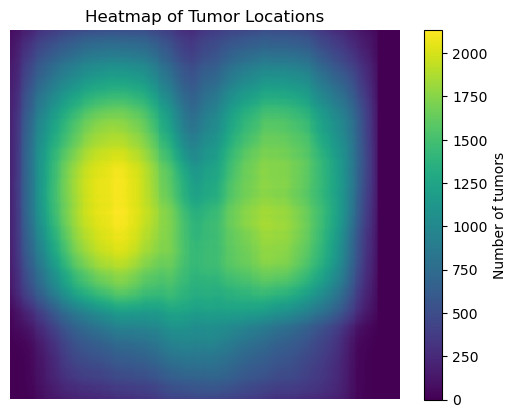

In [33]:
heatmap = np.zeros((IMG_HEIGHT, IMG_WIDTH))

for i in range(len(train_labels)):
    xmin, ymin, xmax, ymax = train_labels.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    heatmap[int(xmin):int(xmax), int(ymin):int(ymax)] += 1
    
plt.imshow(heatmap, origin='lower')
plt.axis('off')
plt.colorbar(label='Number of tumors')
plt.title('Heatmap of Tumor Locations')
plt.show()

The heatmap indicates that the tumors are primarily situated in the center of the brain scans. Interestingly, they appear to form two somewhat distinct clusters - one in the middle-left and the other in the middle-right of the scans, with a few outliers at the bottom between these clusters. This pattern could be attributed to the structure of the brain and the tendency of tumors to occur in certain brain regions.

The resulting images should be displayed with the bounding boxes around the tumors, if present, as in the example below:

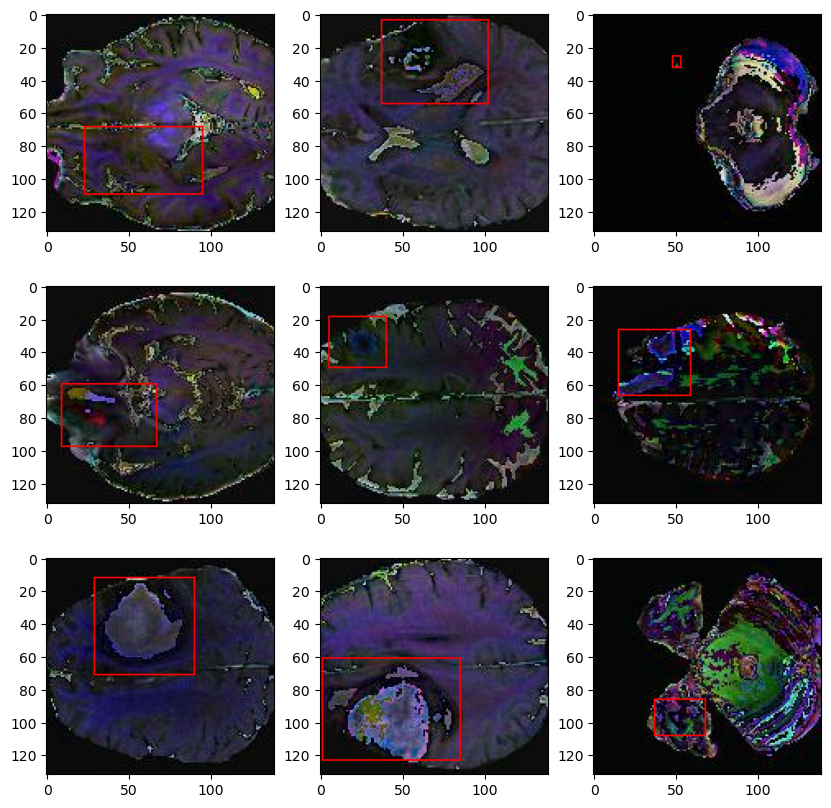

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    img = train_images[i]
    xmin, ymin, xmax, ymax, _ = list(map(int, train_labels.loc[i]))
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
    ax.imshow(img)

Now for some statistics about the images:

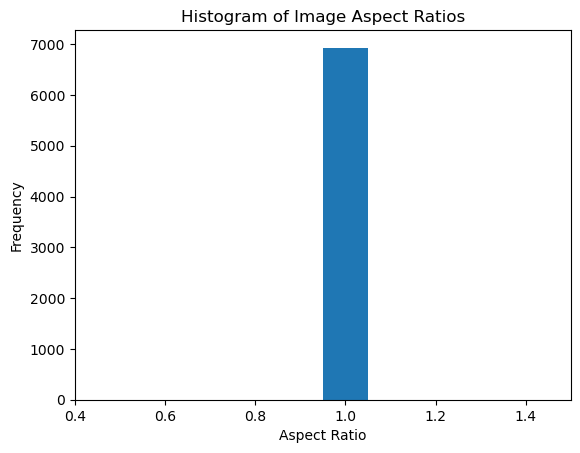

In [37]:
# Calculate the aspect ratio of each image
aspect_ratios = [img_width / img_height for img_width, img_height in [img.shape[:2] for img in train_images]]

# Plot the histogram
plt.hist(aspect_ratios, bins=10)
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Image Aspect Ratios')
plt.show()


The uniformity in aspect ratio and dimensions across all images is beneficial as it eliminates the need for resizing during model training. Given the dimensions of the images are $132\times 139\times 3$, each image will present $51,708$ features - a substantial number indeed.

We're going to delve deeper into the color distribution within the images. By plotting histograms of pixel values for each color channel - Red, Green, and Blue, we can visualize how colors are distributed across the images.

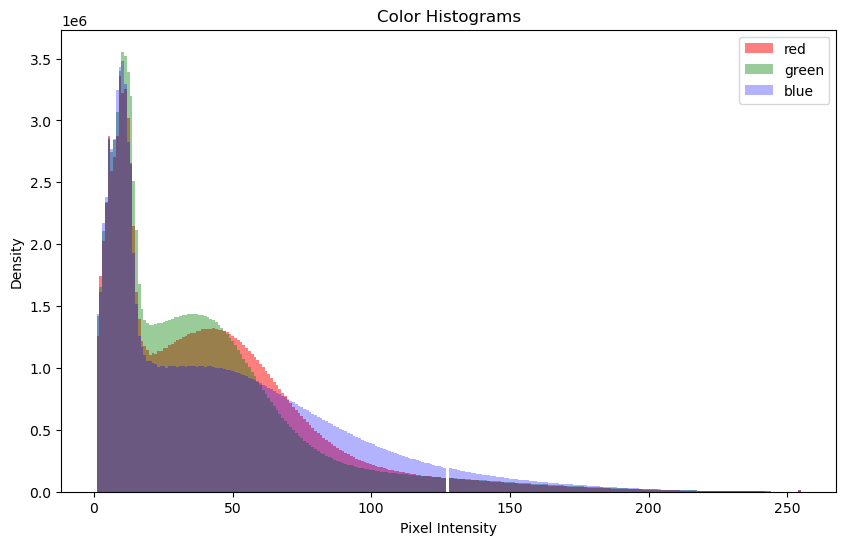

In [38]:
# Flatten the images and separate color channels
red = np.array([image[:, :, 0].flatten() for image in train_images]).flatten()
green = np.array([image[:, :, 1].flatten() for image in train_images]).flatten()
blue = np.array([image[:, :, 2].flatten() for image in train_images]).flatten()

red = red[red != 0]
green = green[green != 0]
blue = blue[blue != 0]

plt.figure(figsize=(10, 6))
plt.hist(red, label='red', bins=256, density=False, color='red', alpha=0.5)
plt.hist(green, label='green', bins=256, density=False, color='green', alpha=0.4)
plt.hist(blue, label='blue', bins=256, density=False, color='blue', alpha=0.3)

plt.title('Color Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

The images appear predominantly dark, with two notable peaks in the histograms, one near 0 and another around 50. This suggests a low dynamic range in the images, with a majority of pixel values gathered towards the lower end of the spectrum. This characteristic could be attributed to the type of brain scans and the imaging technique employed. The histograms reveal a fairly even distribution of pixel values across all color channels, devoid of any significant outliers or irregularities.

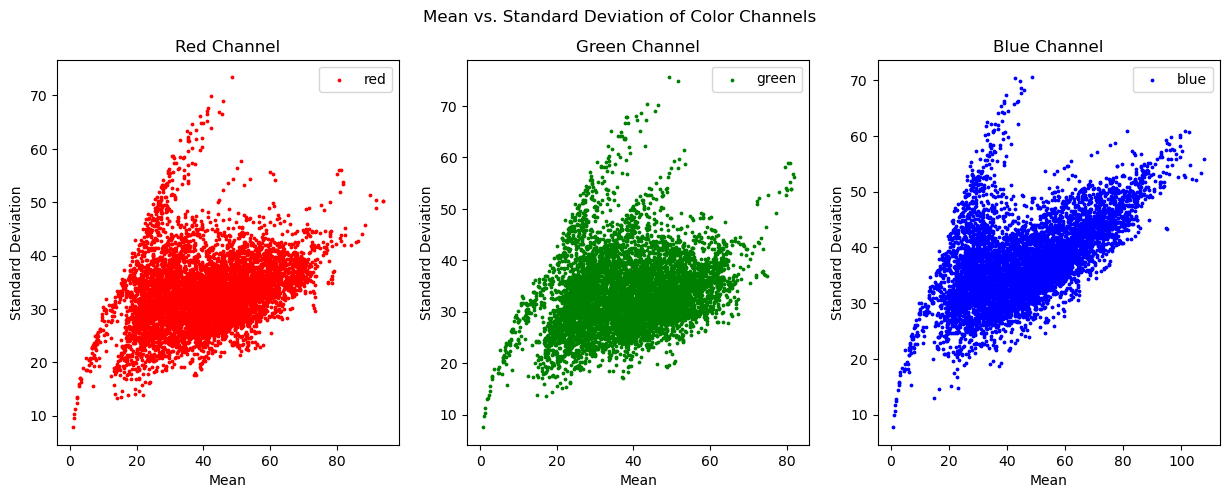

In [39]:
color_df = pd.DataFrame(columns=['red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std'])
channels = ['red', 'green', 'blue']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for channel in channels:
    color_df[f'{channel}_mean'] = [np.mean(img[:, :, channels.index(channel)]) for img in train_images]
    color_df[f'{channel}_std'] = [np.std(img[:, :, channels.index(channel)]) for img in train_images]
    ax = axes[channels.index(channel)]
    ax.scatter(color_df[f'{channel}_mean'], color_df[f'{channel}_std'], label=channel, c='r' if channel == 'red' else 'g' if channel == 'green' else 'b', s=3)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Standard Deviation')
    ax.set_title(f'{channel.capitalize()} Channel')
    ax.legend()
    
fig.suptitle('Mean vs. Standard Deviation of Color Channels')
plt.show()


The plot corroborates our earlier observation that the images are largely dark, with pixel values primarily clustered towards the lower end of the scale. The variation in pixel values across the color channels is relatively minimal. Furthermore, we observe a large cluster of pixel values, suggesting a lack of diversity in the color distribution of the images. This implies that color information might not be as crucial in differentiating between tumor and non-tumor regions in the images. Instead, other features like texture and shape could be more significant in detecting tumors.

# Model Training

Having conducted an analysis of the data and understood the properties of the tumors, we can now move forward with the training of a model to identify brain tumors in the images. Our aim is to construct a reliable and precise tumor detection system, striving for high performance in metrics such as *accuracy*, *precision*, *recall*, and *F1 score*. We will explore various deep learning architectures, loss functions, optimizers, and hyperparameters in our quest to optimize the model's performance and secure the most favorable outcomes.

To identify brain tumors in the images, we will employ deep learning methods grounded in some of the most renowned and efficient architectures in computer vision, including *R-CNN*, *YOLO*, and *SSD*. Additionally, we will devise and implement our own custom architectures.

Our evaluation will concentrate on the following metrics:

- **IoU (Intersection over Union)**: $\frac{Area of Overlap}{Area of Union}$<br>
IoU quantifies the overlap between the predicted bounding box and the ground truth bounding box. It is a crucial metric for evaluating the accuracy of object detection models, as it measures the degree of overlap between the predicted and actual bounding boxes.

- **Recall**: $\frac{TP}{P}$<br>
Recall quantifies the ratio of true positives predicted to the total actual positives in the dataset. It reflects the model's proficiency in correctly identifying positive cases and minimizing false negatives.

- **Precision**: $\frac{TP}{TP+FP}$<br>
Precision calculates the ratio of true positives predicted to all positive predictions made by the model. It reflects the model's precision in identifying positive cases and minimizing false positives.

- **F1 score**: $\frac{2\cdot Precision \cdot Recall}{Precision + Recall}$<br>
The F1 score is a measure used to evaluate a classification model's accuracy. It considers both precision and recall (sensitivity).

- **Confidence**: <br>
Confidence measures the model's certainty in its predictions. It is expressed as a numerical value between 0 and 1, with higher values indicating greater confidence in the model's predictions.

- **F1-Confidence curve** <br>
The F1-Confidence curve is a visual representation of the relationship between the F1 score and the confidence threshold used for predictions. It offers insights into the trade-off between precision and recall at various confidence levels, enabling us to optimize the model's performance based on the preferred balance between precision and recall.


In [40]:
EPOCHS = 15
BATCH = 128
IMG_SIZE = 140

In [41]:
def plot_image(path):
    img = mpimg.imread(path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Custom Models

Our initial approach involves creating and implementing a basic neural network to identify tumors in the images. We'll utilize the PyTorch library for this task, a widely-used deep learning framework that offers an extensive array of tools and features for constructing and training neural networks.

Initially, we must create a custom dataset class for loading and preprocessing the images and labels. Additionally, we need to design a custom neural network architecture for detecting brain tumors in the images.

In [42]:
class TumorsDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_path, label = self.data_list.iloc[idx]
        image = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

This class takes a data_list parameter, which is a list of tuples. Each tuple includes the image path and its associated label, facilitating the easy loading and preprocessing of images and labels from the dataset. However, the current structure of the dataset doesn't align with this, necessitating some adjustments.

In [43]:
def read_dataset(data_dir):
    data_list = pd.DataFrame(columns=['image_path', 'label'])
    img_dir = os.path.join(data_dir, 'images')
    for root, _, files in os.walk(img_dir):
        for i, file in enumerate(files):
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                label_name = image_path.replace('.jpg', '.txt')
                label_path = os.path.join(data_dir, 'labels', label_name.split('/')[-1] )
                with open(label_path, 'r') as f:
                    label = f.readline().strip().split()[1:]
                    label = [float(x) for x in label]
                    if len(label) == 0:
                        continue
                    label = fix_label(label, (132, 139))
                    data_list.loc[i] = [image_path, label]
                    
    return data_list

def fix_label(label, img_size):
    x, y, w, h = label
    xmin = (x - w / 2) * img_size[0]
    ymin = (y - h / 2) * img_size[1]
    xmax = (x + w / 2) * img_size[0]
    ymax = (y + h / 2) * img_size[1]
    return xmin, ymin, xmax, ymax

With those two functions, we can now load the dataset in the appropriate format.

In [44]:
train_data_list = read_dataset(TRAIN_PATH)
valid_data_list = read_dataset(VALID_PATH)
test_data_list = read_dataset(TEST_PATH)

train_data_list.head()

image_path  \
0  /Users/benarviv/Documents/OpenU/2024א/Data Sci...   
1  /Users/benarviv/Documents/OpenU/2024א/Data Sci...   
2  /Users/benarviv/Documents/OpenU/2024א/Data Sci...   
3  /Users/benarviv/Documents/OpenU/2024א/Data Sci...   
4  /Users/benarviv/Documents/OpenU/2024א/Data Sci...   

                                               label  
0  (21.84172661870504, 71.60606060606061, 91.1654...  
1  (35.13669064748201, 3.15909090909091, 96.86330...  
2  (45.58273381294964, 26.325757575757574, 51.280...  
3  (8.54676258992806, 62.12878787878788, 63.62589...  
4  (5.697841726618704, 18.954545454545453, 37.985...

Excellent! We're now able to generate the dataset objects and load the data. We'll convert the images and labels into tensors to feed them into the neural network. The DataLoader class enables us to iterate over the dataset in batches, a crucial aspect of efficient model training. We've selected a batch size of 32.

In [45]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = TumorsDataset(train_data_list, transform=transform)
val_dataset = TumorsDataset(valid_data_list, transform=transform)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
test_dataset = TumorsDataset(test_data_list, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(next(iter(train_loader)))

[tensor([[[[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314]],

         [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314]],

         [[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 

Now we can finally define the neural network architecture. For our first attempt, we will design a (very) simple network, without any convolutional layers, just to see how it performs on an object detection task.

The network will consist of a single linear layer, followed by a `ReLU` activation function, a dropout layer, and another linear layer that will output the bounding box coordinates. We will use the `MSELoss` loss function to calculate the loss between the predicted and ground truth bounding box coordinates, and the `Adam` optimizer to update the model parameters during training.

In [69]:
def init_model(attempt):
    if attempt == 1:
        model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(132 * 139 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4)
        )
    elif attempt == 2:
        model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64 * 17 * 16, 128),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 4)    
        )
    
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() > 1:
            torch.nn.init.xavier_uniform_(param)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion

In [59]:
model, optimizer, criterion = init_model(attempt=1)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=55044, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=4, bias=True)
)


It is time to train the model. The training loop will iterate over the dataset for a specified number of epochs, compute the loss, update the model parameters, and evaluate the model's performance on the validation set. We will also use the validation set to implement early stopping, in order to prevent overfitting and improve the model's generalization ability. After choosing the epoch that minimizes the validation loss, we will train the model on the entire dataset for that number of epochs.

In [57]:
def train(attempt, epochs=50, patiance=5, early_stopping=True):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    best_epoch = 0
    epochs_no_improve = 0
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        val_losses.append(val_loss / len(val_loader))
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if early_stopping and epochs_no_improve == patiance:
            print(f'Early stopping at epoch {epoch}')
            break
      
    print(f'Best epoch: {best_epoch}, Best validation loss: {best_val_loss}')
    print('Retraining the model on the combined dataset')
    init_model(attempt=attempt)
    for epoch in tqdm(range(best_epoch)):
        model.train()
        train_loss = 0.0
        for images, labels in combined_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
    return train_losses, val_losses

In [60]:
train_losses, val_losses = train(attempt=1, epochs=100)

 27%|██▋       | 27/100 [02:50<07:39,  6.30s/it]


Early stopping at epoch 27
Best epoch: 22, Best validation loss: 509.8475797059106
Retraining the model on the combined dataset


100%|██████████| 22/22 [02:28<00:00,  6.75s/it]


The early stopping mechanism has stopped the training process after 27/100 epochs, as the validation loss has not improved for 5 consecutive epochs. Training the model took only a few minutes, which is expected given the simplicity of the network. We can now evaluate the model's performance on the test set and visualize the predictions.

The validation loss will be the first metric we will look at. We will plot the training and validation loss curves to assess the model's performance and identify any signs of overfitting or underfitting.

In [61]:
def plot_losses(train_loss, val_acc, loss_fn=None):
    plt.semilogy(train_loss, label='Train Loss', color='red', linestyle='dashed', alpha=0.5)
    plt.semilogy(val_acc, label='Validation Loss', color='black')
    if loss_fn:
        plt.title(loss_fn)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

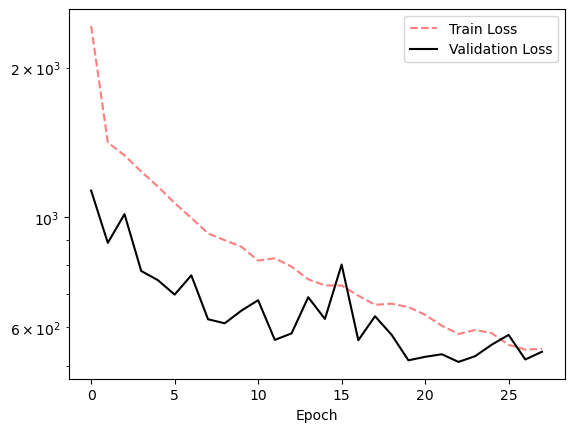

In [62]:
plot_losses(train_losses, val_losses)

We can see that the loss is very high, and there is a large gap between the training and validation loss curves, indicating that the model is not performing well on the validation set. Based on the simplicity of the network, it is reasonable to assume that the model is underfitting the data, and we need to improve the model's architecture and hyperparameters to achieve better performance.

In any case, we will visualize the predictions made by the model on the test set, to get a sense of how well the model is detecting the tumors in the images.

In [63]:
def plot_predictions(model, loader):
    model.eval()
    images, labels = next(iter(loader))
    
    with torch.no_grad():
        predictions = model(images)
    
    predicted_bboxes = predictions.detach().numpy()
    image_arrays = images.detach().numpy().transpose(0, 2, 3, 1)
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 15))
    for i, ax in enumerate(axes.flat):
        image = F.to_pil_image(image_arrays[i])
        image_width, image_height = image.size
        true_bbox = labels[i].numpy()
        pred_bbox = predicted_bboxes[i]
        ax.imshow(image)
        
        true_xmin, true_ymin, true_xmax, true_ymax = true_bbox
        true_width = true_xmax - true_xmin
        true_height = true_ymax - true_ymin
        true_bbox = plt.Rectangle((true_xmin, true_ymin), true_width, true_height, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(true_bbox)
        
        pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin
        pred_bbox = plt.Rectangle((pred_xmin, pred_ymin), pred_width, pred_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(pred_bbox)
        
        ax.set_title(f'Image #{i + 1}')

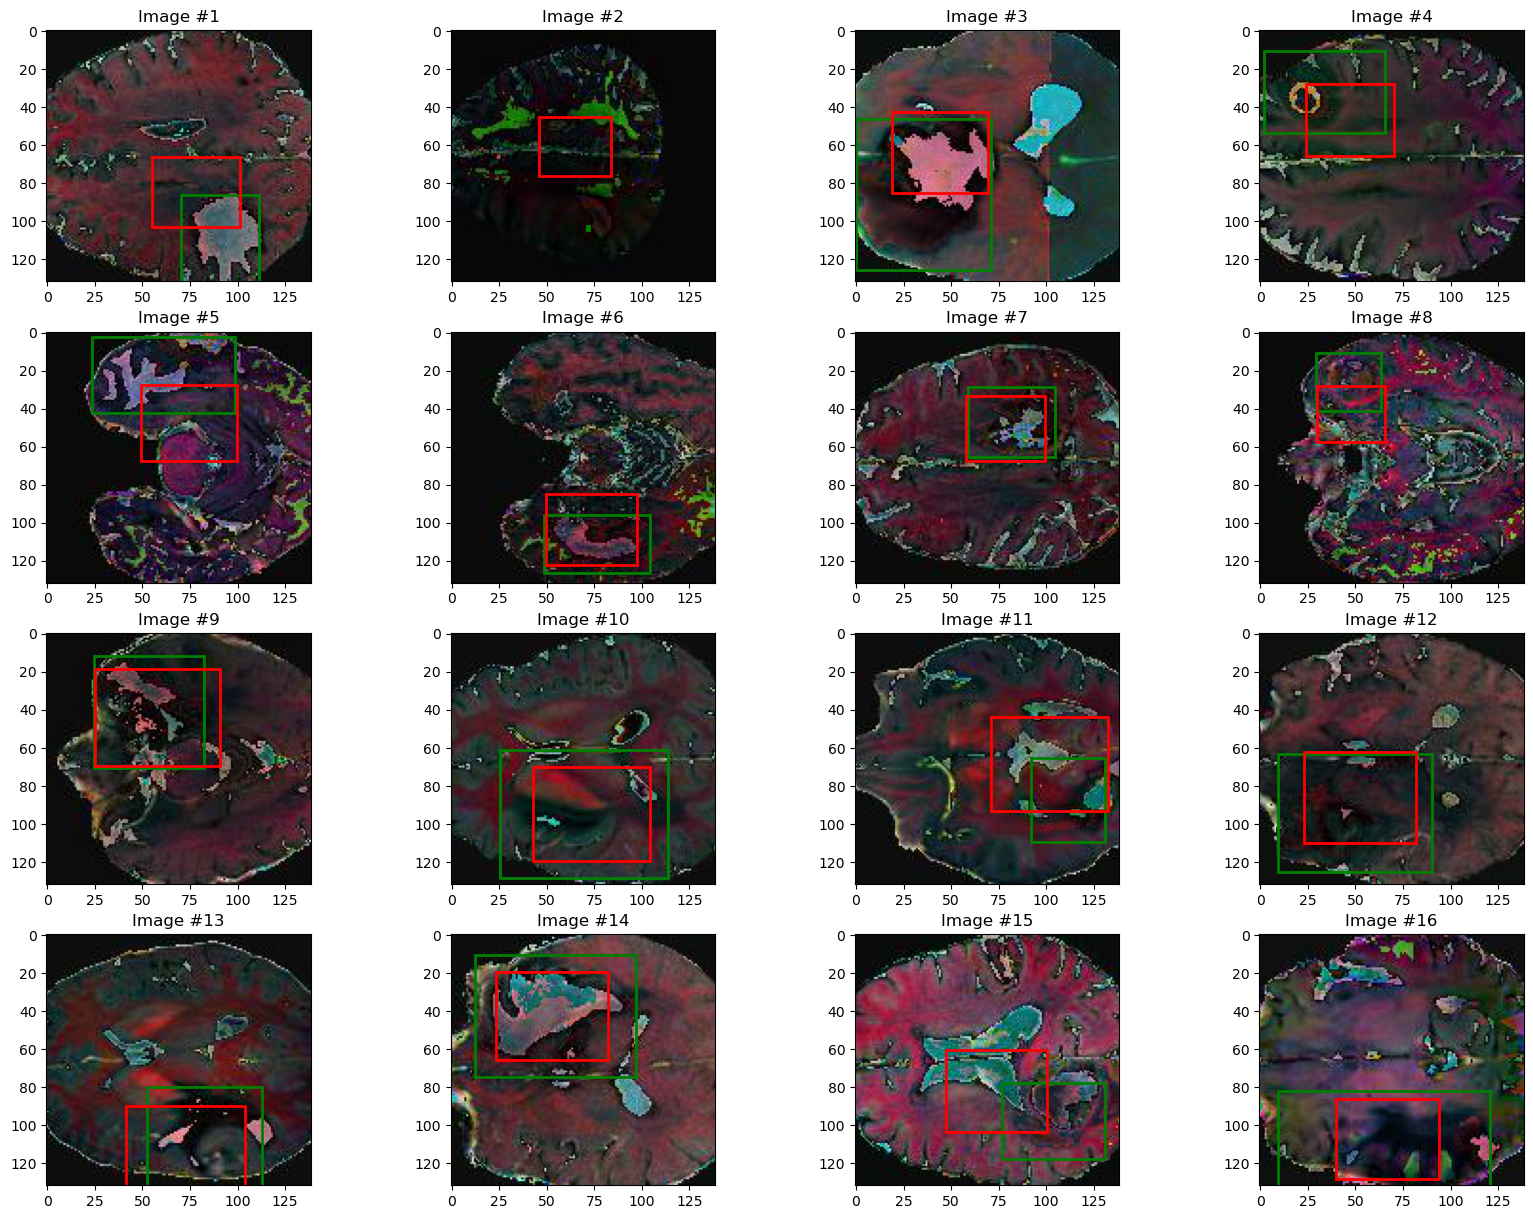

In [64]:
plot_predictions(model, test_loader)

Surprisingly, the model is performing quite well, considering its simplicity. Although the bounding boxes are not very precise, there is an overlap between the predicted and ground truth bounding boxes, indicating that the model is able to detect the tumors in the images.

We will evaluate the model's performance using the *Intersection over Union (IoU)* metric, which measures the overlap between the predicted and ground truth bounding boxes. We will calculate the IoU for each image in the test set.

In [65]:
def bbox_iou(box1, box2):
    # Calculate the coordinates of the intersection of the two boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate the area of the intersection
    intersection = max(0, abs(x2 - x1)) * max(0, abs(y2 - y1))

    # Calculate the area of each box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection / (box1_area + box2_area - intersection)

    return iou

In [77]:
def eval_test(model, loader):
    model.eval()
    true_boxes = []
    predicted_boxes = []
    TP = 0
    FP = 0
    FN = 0

    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            outputs = model(images)
            true_boxes.extend(labels)
            predicted_boxes.extend(outputs)
            ious = [bbox_iou(output, label) for output, label in zip(outputs, labels)]
            TP += sum(iou > 0.5 for iou in ious)
            FP += sum(iou <= 0.5 and iou > 0.1 for iou in ious)
            FN += sum(iou <= 0.1 for iou in ious)
            
    confusion_matrix = np.array([[TP, FP], [FN, 0]])
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, square=True, xticklabels=['Tumor', 'Background'], yticklabels=['Tumor', 'Background'])
    plt.ylabel('True box')
    plt.xlabel('Predicted box')
    plt.title('Confusion Matrix')
    
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    print(f'Average Intersection over Union: {np.mean(ious)}')
            
    return precision, recall, f1

100%|██████████| 31/31 [00:02<00:00, 12.68it/s]


Average Intersection over Union: 0.5120066404342651
Precision: 0.67
Recall: 0.87
F1 Score: 0.75


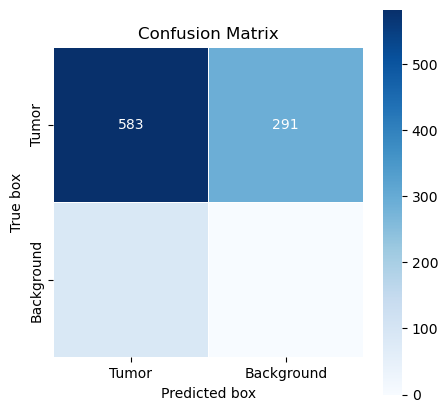

In [78]:
precision, recall, f1 = eval_test(model, test_loader)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

As can be seen from the confusion matrix, the model performs quite poorly, as most of the predictions are located outside of the diagonal, indicating a high number of false positives and false negatives. We can also see that the *precision* and *F1 score* are pretty low.

This shallow model correctly classifies the bounding boxes of about a third of the images, which is not bad at all for a very simple network. However, this result isn't satisfactory, and we will need to improve the model's performance by using more advanced architectures and techniques.

Our second attempt will be to implement a more sophisticated neural network architecture, such as a *Convolutional Neural Network (CNN)*, which is well-suited for image classification and object detection tasks.

In [72]:
model, optimizer, criterion = init_model(attempt=2)
print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.4, inplace=False)
  (14): Linear(in_features=17408, out_features=128, bias=True)
  (15): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

This is a much more complex network. It consists of multiple convolutional layers, followed by *batch normalization* layers, *ReLU* activation functions, *max pooling* layers, *dropout* layers and *fully connected* layers. Let's see if this network performs better than the previous one. In contrast to the previous network, this one might take a while to train. 

In [73]:
train_losses, val_losses = train(attempt=2, epochs=100, patiance=10)

 61%|██████    | 61/100 [45:57<29:22, 45.20s/it]  


Early stopping at epoch 61
Best epoch: 51, Best validation loss: 146.53349416764055
Retraining the model on the combined dataset


100%|██████████| 51/51 [43:25<00:00, 51.09s/it]


As expected, the training process took almost an hour, and the early stopping mechanism stopped the training after 61/100 epochs, as the validation loss has not improved for 10 consecutive epochs. 

But was it worth it? Let's look at the validation loss curve.

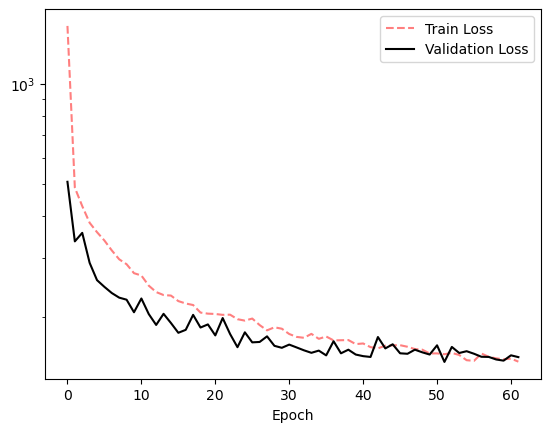

In [74]:
plot_losses(train_losses, val_losses)

We can see a significant difference in the loss curves between the two models. While the previous model's train and validation loss curves seemed to diverge, this model's curves are much closer together, indicating that the model is performing better on the validation set.

Next, we will plot some of the predictions made by the model on the test set.

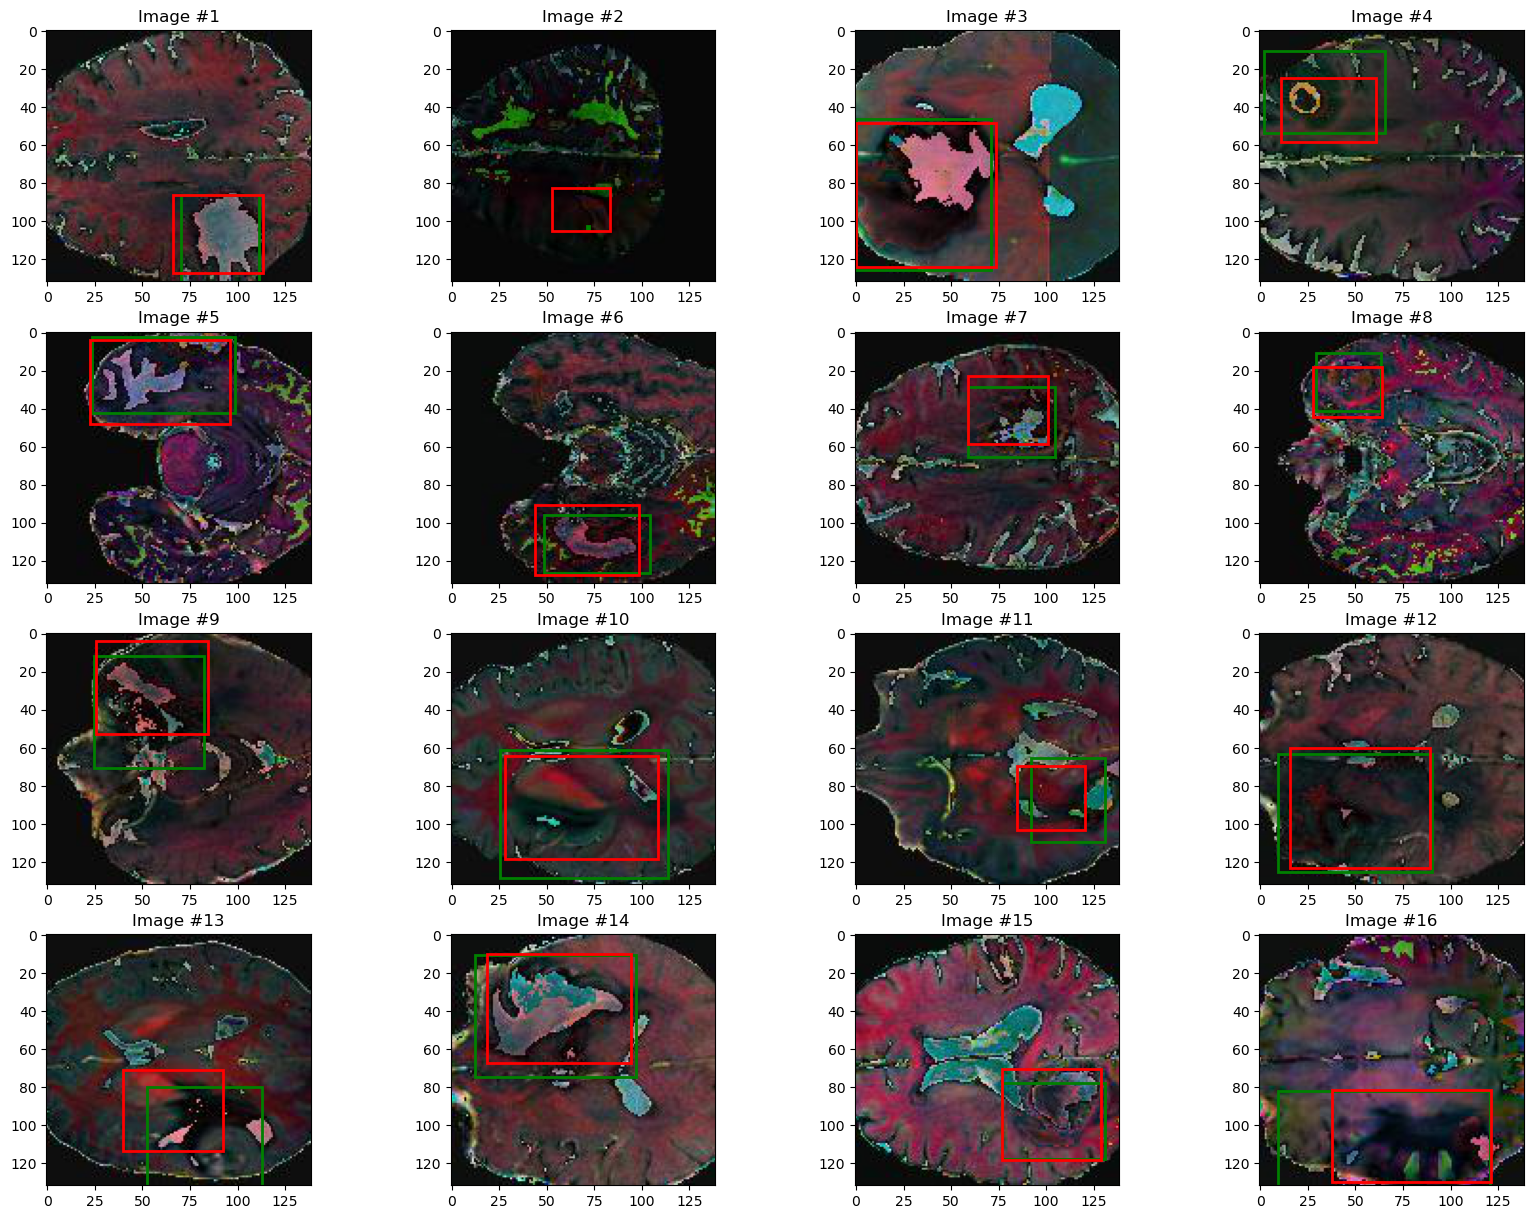

In [75]:
plot_predictions(model, test_loader)

Still not perfect, but the model is better at detecting areas of interest in the images, and the bounding boxes seem to be more precise than the previous model. Let's evaluate the model's performance, similarly to the previous model.

100%|██████████| 31/31 [00:02<00:00, 12.98it/s]


Intersection over Union: 0.6060290932655334
Precision: 0.67
Recall: 0.87
F1 Score: 0.75


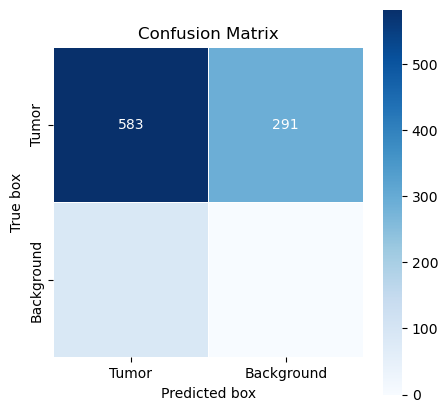

In [76]:
precision, recall, f1 = eval_test(model, test_loader)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

That's a significant improvement! The model correctly classifies the bounding boxes of about two thirds of the images, more than three times better than the previous model. The *precision* and *F1 score* are also much higher, indicating that the model is performing well on the test set.

It's time to try a different approach. We will use **YOLOv8**'s pre-trained model, which is a state-of-the-art object detection model that has been trained on a large dataset of images and is capable of detecting objects with high accuracy and precision. 

## YOLOv8 Based Models

The **You Only Look Once (YOLO)** algorithm is a popular object detection algorithm that is known for its speed and accuracy. YOLO divides the image into a grid and predicts bounding boxes and class probabilities for each grid cell.

### First Attempt - YOLOv8n

The `YOLOv8n` model is the smallest version of the YOLOv8 architecture, and is optimized for speed and efficiency. We will begin by training this model on our train and validation datasets for 15 epochs, because it is the fastest and simplest model to train.

In [83]:
%%writefile tumor_v8n.yaml
path: '/Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/Clean' 
train: 'train/images'
val: 'valid/images'

#class names
names:
    0: 'Tumor'

Overwriting tumor_v8n.yaml


In [84]:
model = YOLO('yolov8n.pt')

In [85]:
results = model.train(
    data = 'tumor_v8n.yaml',
    imgsz = IMG_SIZE,
    epochs = EPOCHS,
    batch = BATCH,
    name = 'Output (n)'
)

New https://pypi.org/project/ultralytics/8.2.16 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2 🚀 Python-3.11.0 torch-2.2.0 CPU (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=tumor_v8n.yaml, epochs=15, time=None, patience=100, batch=128, imgsz=140, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Output (n), exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/Clean/train/labels.cache... 6745 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6745/6745 [00:00<?, ?it/s]
val: Scanning /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/Clean/valid/labels.cache... 1944 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1944/1944 [00:00<?, ?it/s]


Plotting labels to runs/detect/Output (n)/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 160 train, 160 val
Using 0 dataloader workers
Logging results to runs/detect/Output (n)
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      1.906      2.234      1.502        181        160: 100%|██████████| 53/53 [03:06<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]

                   all       1944       1944      0.748      0.538      0.598      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G      1.703      1.403      1.357        169        160: 100%|██████████| 53/53 [03:11<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]

                   all       1944       1944      0.713      0.528      0.564      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G      1.666      1.314      1.339        150        160: 100%|██████████| 53/53 [03:10<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]

                   all       1944       1944      0.659       0.48      0.529       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G       1.65      1.259      1.326        162        160: 100%|██████████| 53/53 [03:10<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]

                   all       1944       1944      0.775      0.578      0.633      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G      1.604      1.196      1.305        170        160: 100%|██████████| 53/53 [03:09<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.24s/it]

                   all       1944       1944      0.805      0.618      0.682      0.374


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G       1.52      1.111      1.283         89        160: 100%|██████████| 53/53 [03:08<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.24s/it]

                   all       1944       1944      0.813      0.612      0.702      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G      1.468       1.01      1.261         89        160: 100%|██████████| 53/53 [03:08<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]

                   all       1944       1944      0.837      0.674      0.742      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G      1.444     0.9649       1.25         89        160: 100%|██████████| 53/53 [03:08<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]

                   all       1944       1944      0.848      0.654      0.728      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G      1.417     0.9161      1.227         88        160: 100%|██████████| 53/53 [03:07<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.24s/it]

                   all       1944       1944      0.845      0.643       0.74      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G      1.368     0.8838      1.209         89        160: 100%|██████████| 53/53 [03:09<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:26<00:00,  3.27s/it]

                   all       1944       1944      0.836      0.649      0.737      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G      1.343     0.8506      1.194         86        160: 100%|██████████| 53/53 [03:08<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.22s/it]

                   all       1944       1944      0.861      0.695      0.773      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G      1.314     0.8169      1.178         87        160: 100%|██████████| 53/53 [03:10<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.25s/it]

                   all       1944       1944       0.89      0.702      0.785      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G      1.269     0.7826      1.163         87        160: 100%|██████████| 53/53 [03:08<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]

                   all       1944       1944        0.9      0.702      0.786      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G      1.244      0.755      1.148         88        160: 100%|██████████| 53/53 [03:07<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]

                   all       1944       1944      0.891      0.719      0.797      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15         0G      1.223     0.7288      1.144         89        160: 100%|██████████| 53/53 [03:08<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]

                   all       1944       1944      0.898      0.719        0.8      0.502



15 epochs completed in 0.899 hours.
Optimizer stripped from runs/detect/Output (n)/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/Output (n)/weights/best.pt, 6.2MB

Validating runs/detect/Output (n)/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.11.0 torch-2.2.0 CPU (Apple M2 Pro)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]


                   all       1944       1944      0.899      0.719        0.8      0.502
Speed: 0.1ms preprocess, 11.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/Output (n)


This is a relatively fast model, and it took us about 30 minutes to train it on the dataset. Now we are able to discuss its performance.

In [178]:
output_dir = 'runs/detect/Output (n)'
f1_curve = os.path.join(output_dir, 'F1_curve.png')
confusion_matrix = os.path.join(output_dir, 'confusion_matrix.png')
results = os.path.join(output_dir, 'results.png')

The YOLO model provides numerous metrics for evaluating its performance, including *precision*, *recall*, *F1 score*, and *confidence*. We begin by examining the model's loss on the train and validation sets.

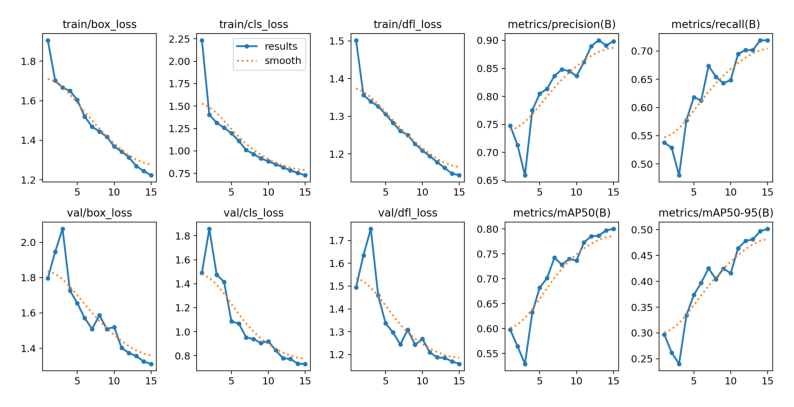

In [179]:
plot_image(results)

In the initial 15 epochs, the model shows signs of improvement in both its classification and bounding box loss metrics. However, the overall loss remains high, and the lack of convergence suggests that the model's performance is still suboptimal. This indicates that while some progress has been made, the results are likely to be unsatisfactory, highlighting significant potential for further enhancement.

The confusion matrix might provide a more detailed view of the model's performance on the validation set.

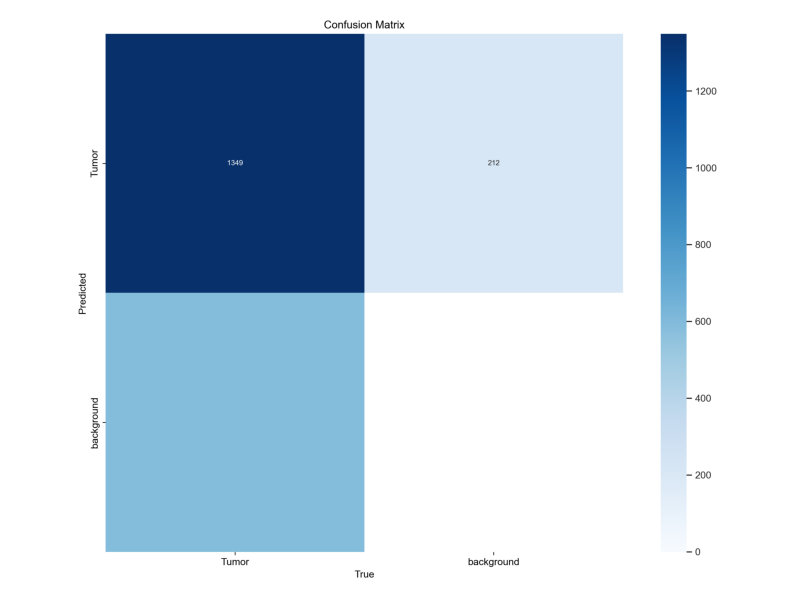

In [79]:
plot_image(confusion_matrix)

As expected, the results are okay, but not great. Ideally, we want the diagonal cells to be as dark as possible, indicating accurate predictions, and the off-diagonal cells to be as light as possible, suggesting minimal false positives and false negatives. The current output suggests that the model is struggling to accurately detect and classify tumors in the images.

Next, we will visualize the *F1-Confidence curve*. A good model should have a high F1 score at a high confidence threshold, indicating that it is making accurate predictions with high confidence.

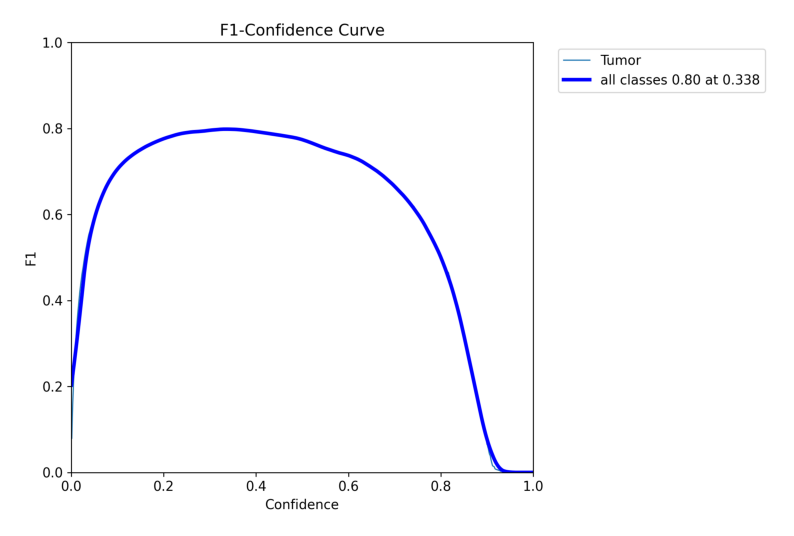

In [180]:
plot_image(f1_curve)

We can infer from the plot that the model lacks high confidence in its predictions, with its peak F1 score occurring at a relatively low confidence threshold. Around a confidence threshold of 0.6, the F1 score drastically drops, indicating that the model struggles to make accurate predictions with high confidence, resulting in diminished effectiveness.

### Second Attempt - YOLOv8s

In our second attempt, we will train the `YOLOv8s` model for a longer period of time - 100 epochs, to see if the model's performance improves with additional training.

In [51]:
%%writefile tumor_v8s.yaml
path: '/Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/Clean'
train: 'train/images'
val: 'valid/images'
test: 'test/images'

#class names
names:
    0: 'Tumor'

Overwriting tumor_v8s.yaml


In [105]:
model = YOLO('yolov8s.pt')

In [ ]:
results = model.train(
    data = 'tumor_v8s.yaml',
    imgsz = IMG_SIZE,
    epochs = 100,
    batch = BATCH,
    name = 'Output (s)'
)

In [185]:
output_dir = 'runs/detect/Output (s)'
f1_curve = os.path.join(output_dir, 'F1_curve.png')
confusion_matrix = os.path.join(output_dir, 'confusion_matrix.png')
results = os.path.join(output_dir, 'results.png')

Just as before, we will start by visualizing the loss curves for the train and validation sets.

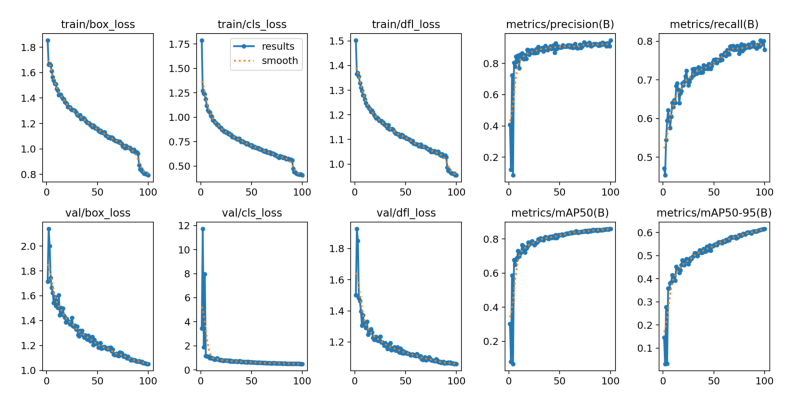

In [187]:
plot_image(results)

We can observe a significant improvement in the results of this model, with the loss reaching a much lower value than the previous model. For instance, the *train/box_loss* has decreased to 0.8 from 1.2. The graphs also indicate the beginning of convergence, suggesting that the model could achieve its peak performance if trained for additional 50-100 epochs. However, it is worth noting that training this model took significantly longer than the previous one - about 6 hours, compared to 30 minutes.

Let's take a look at the *confusion matrix*, to see if the model's performance indeed improved.

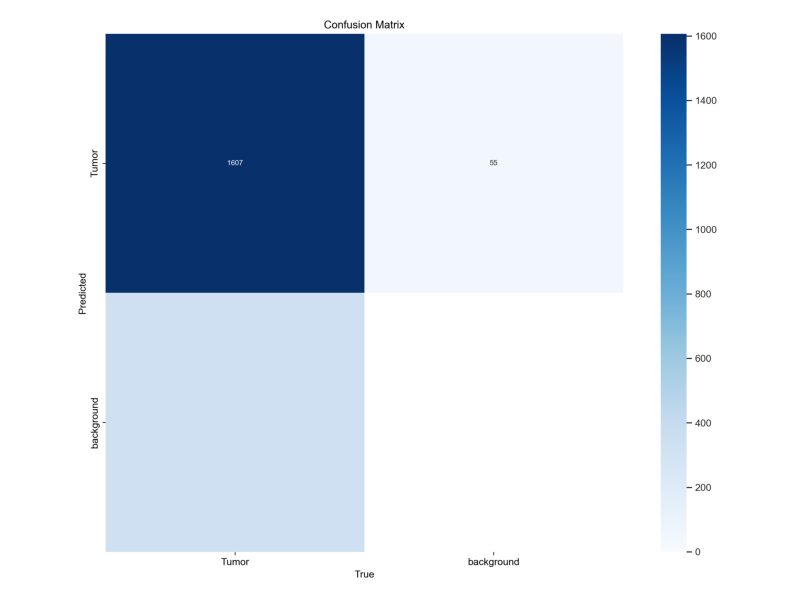

In [188]:
plot_image(confusion_matrix)

We are now seeing a much better confusion matrix, with darker diagonal cells and lighter off-diagonal cells, indicating that the model is making more accurate predictions. This is a significant improvement over the previous model, and suggests that the additional training has had a positive impact on the model's performance.

The previous model's *F1-Confidence curve* was not very promising. Let's see if this model's curve looks any better.

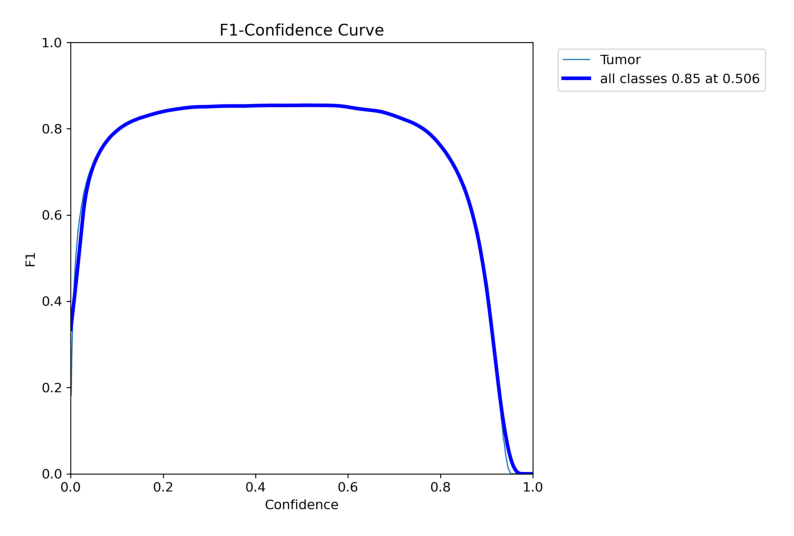

In [189]:
plot_image(f1_curve)

And it does! The F1 score is much higher at higher confidence thresholds, indicating that the model is making more accurate predictions with greater confidence. The model peaks at an F1 score of 0.85, compared to the previous model's peak of 0.8, with a much higher confidence level - 0.506. The curve starts to diminish around a confidence threshold of 0.8. This is a significant improvement over the previous model, exhibiting improved confidence and accuracy in its predictions.

Nevertheless, given the critical nature of detecting brain tumors, where accuracy and precision are paramount, the model must be as accurate as possible, even if it requires longer training times. The second model shows significant overall improvement compared to the first model and the custom models we trained earlier, although there is still room for further enhancement. With better resources and computational power, we could potentially train the model for additional epochs to achieve even better results.